# Burbank Dataset Analysis

## Import Required Packages:

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import codecs
import os
import matplotlib.pyplot as plt 

import tensorflow as tf
tf.keras.backend.clear_session()
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, Embedding, concatenate, Dropout
from tensorflow.keras.optimizers import Adam,  SGD
from tensorflow.keras.regularizers import l2
import joblib

from tensorflow.keras.metrics import RootMeanSquaredError as RMSE
from tensorflow.keras import backend as K

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score, f1_score, auc, roc_curve
from sklearn.model_selection import train_test_split, GroupShuffleSplit

# Change to your own filepath below

dat_path = "Data/{0}"
mod_name = "PHQ9_Risk"
vers = 2


/Users/sean/opt/anaconda3/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.2)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## Functions for saving best model, group shuffle split and creating cleaned subgroup categories:

In [3]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_loss', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()


def group_split(X, y, group, train_size = 0.80):
    splitter = GroupShuffleSplit(train_size = train_size)
    train, test = next(splitter.split(X, y, groups = group))
    
    return (X.iloc[train], X.iloc[test], y.iloc[train], y.iloc[test])

def cleanMaritalStatus(x):
    if pd.isnull(x):
        return "Unknown"
    elif x == "Single":
        return x
    elif x in ["Married","Domestic Partner","Civil Union","Life Partner"]:
        return "In A Relationship"
    elif x in ["Legal Separation","Widowed","Divorced","Separated"]:
        return "Separated"
    else:
        return "Unknown"
    
def cleanAlcohol(x):
    if x > 10:
        return "Unknown"
    elif x > 4.2:
        return "Alcoholic"
    elif x >= 1.2 and x < 4.2:
        return "Drinks Heavily"
    elif x > 0 and x < 1.2:
        return "Drinks Casually"
    elif x == 0:
        return "Doesn't Drink"
    else:
        return "Unknown"
    
def cleanSmoke(x):
    if x > 3:
        return "Unknown"
    elif x > 1:
        return "Heavy Smoker"
    elif x >= 0.33 and x < 1:
        return "Moderate Smoker"
    elif x > 0 and x < 0.33:
        return "Occasional Smoker"
    elif x == 0:
        return "Doesn't Smoke"
    else:
        return "Unknown"
    
def cleanAge(x):
    if x >= 18 and x < 25:
        return "18-24"
    elif x >= 25 and x < 35:
        return "25-35"
    elif x >= 35 and x < 49:
        return "35-49"
    elif x >= 49 and x < 65:
        return "49-65"
    elif x >= 65:
        return "65+"
    else:
        return x
    
def cleanAlcoholUse(x):
    if pd.isnull(x):
        return "Unknown"
    elif x == 'Not Asked':
        return "Unknown"
    elif x in ['Not Currently', 'Never']:
        return "No"
    else:
        return x
    
def cleanIns(x):
    if pd.isnull(x):
        return "Unknown"
    elif x == 'Commercial':
        return "Employed"
    else:
        return "Unemployed"
    
def raceManip(x):
    if pd.isnull(x):
        return "Unknown" 
    elif x in ['Declines to List', 'Unknown/Unavailable']:
        return "Unknown"
    else:
        return x
    
def ethnManip(x):
    if pd.isnull(x):
        return "Unknown" 
    elif x in ['DECLINES TO LIST', 'Unknown or Unavailable']:
        return "Unknown"
    else:
        return x

## Import Data:

In [5]:
enc_dat = pd.read_csv(dat_path.format("d1853463_ENC_20220711.csv"))
lab_dat = pd.read_csv(dat_path.format("d1853463_LAB_20220711.csv"))
med_dat = pd.read_csv(dat_path.format("d1853463_MED_20220711.csv"))
pat_dat = pd.read_csv(dat_path.format("d1853463_PAT_20220711.csv"))
pat_dat_cat = pd.read_excel("coded_pat_data_for_cat.xlsx", engine = "openpyxl", sheet_name = None)

# Data Cleaning and Reshaping

## Modified Categorical Variables:

In [6]:
pd.options.mode.chained_assignment = None

pat_dat_sum = pat_dat[["CODED_PAT_ID","AGE_AT_COHORT_ENTRY","SEX","MARITAL_STATUS","SMOKING_PACKS_PER_DAY","ALCOHOLIC_DRINKS_PER_DAY","CIGS_YN","ALCOHOL_USE_YN","RACE","ETHNICITY","INS_TYPE"] + 'RENAL_FLG	CANC_FLG	IMMUN_FLG	HTN_FLG	DM_FLG	CHD_FLG'.split('	')]
pat_dat_sum["AGE_AT_COHORT_ENTRY"] = pat_dat_sum["AGE_AT_COHORT_ENTRY"].apply(lambda x : float(x))
pat_dat_sum["MARITAL_STATUS"] = pat_dat_sum["MARITAL_STATUS"].apply(lambda x : cleanMaritalStatus(x))
pat_dat_sum["ALCOHOLIC_DRINKS_PER_DAY"] = pat_dat_sum["ALCOHOLIC_DRINKS_PER_DAY"].apply(lambda x : np.mean([float(x.replace("+","").strip()) for x in x.rsplit("-")]) if type(x) is str else float(x))
pat_dat_sum["SMOKING_PACKS_PER_DAY"] = pat_dat_sum["SMOKING_PACKS_PER_DAY"].apply(lambda x : np.mean([float(x.replace("+","").strip()) for x in x.rsplit("-")]) if type(x) is str else float(x))
pat_dat_sum["RACE"] = pat_dat_sum["RACE"].apply(lambda x : raceManip(x))
pat_dat_sum["ETHNICITY"] = pat_dat_sum["ETHNICITY"].apply(lambda x : ethnManip(x))
pat_dat_sum["INS_TYPE"] = pat_dat_sum["INS_TYPE"].apply(lambda x : cleanIns(x))

pat_dat_sum["AGE_AT_COHORT_ENTRY"] = pat_dat_sum["AGE_AT_COHORT_ENTRY"].apply(lambda x : cleanAge(x))
pat_dat_sum["ALCOHOLIC_DRINKS_PER_DAY"] = pat_dat_sum["ALCOHOLIC_DRINKS_PER_DAY"].apply(lambda x : cleanAlcohol(x))
pat_dat_sum["SMOKING_PACKS_PER_DAY"] = pat_dat_sum["SMOKING_PACKS_PER_DAY"].apply(lambda x : cleanSmoke(x))
pat_dat_sum["CIGS_YN"].fillna("Unknown", inplace = True)
pat_dat_sum["ALCOHOL_USE_YN"].fillna("Unknown", inplace = True)

for sheet in pat_dat_cat.keys():
    col_name = pat_dat_cat[sheet].columns[0]
    pat_dat_sum = pat_dat_sum.merge(pat_dat_cat[sheet], on = col_name, how = "left")
    del pat_dat_sum[col_name]


## Screening Graph Function:

In [179]:
def screeningGraph(df, pat_id, xaxis):
    
    plt.title("Patient ID: " + pat_id, fontsize=16, y=1.08)
    
    change_from_baseline = float(fin_dat_summary[fin_dat_summary["CODED_PAT_ID"] == pat_id]["PHQ_PERCENT_CHANGE_FROM_BASELINE"])
    
    # X Axis Changer:
    
    if xaxis == "Appt":
        x = "APPT_SINCE_COHORT_ENTRY"
        if len(df[df["CODED_PAT_ID"] == pat_id]) < 25:
            plt.xticks(np.arange(
                min(df[df["CODED_PAT_ID"] == pat_id]["APPT_SINCE_COHORT_ENTRY"]), 
                max(df[df["CODED_PAT_ID"] == pat_id]["APPT_SINCE_COHORT_ENTRY"])+1, 1.0))
        plt.xlabel("Appointment Number", fontsize=14, labelpad=15)
    elif xaxis == "Days":
        x = "DAYS_QUAL_TO_APPT"
        plt.xlabel("Days Since Patient Joined Cohort", fontsize=12, labelpad=10)

        
    else:
        print("valid options for xaxis are 'Appt' and 'Days'")
        return None
    
    plt.ylabel("Screening Score", fontsize=12, labelpad=10)
    
    # Scores to display:
    
    plt.plot(x, "PHQ9_SCORE", data = df[df["CODED_PAT_ID"] == pat_id], zorder=1)
    plt.plot(x, "GAD7_SCORE", data = df[df["CODED_PAT_ID"] == pat_id], zorder=2)
    
    # Prediction Lines:
    x_coords_wrong = list(df[(df["CODED_PAT_ID"] == pat_id) & (df["PHQ_PRED_WRONG"] == 1)][[x]].to_numpy().flatten())
    x_coords_right = list(df[(df["CODED_PAT_ID"] == pat_id) & (df["PHQ_PRED_RIGHT"] == 1)][[x]].to_numpy().flatten())
    if len(x_coords_wrong) != 0:
        plt.vlines(x=x_coords_wrong, ymin=0, ymax=df[df["CODED_PAT_ID"] == pat_id]["PHQ9_SCORE"].max(), alpha=0.5, colors='red', ls=':', lw=2, label='Incorrect Model Prediction')
    if len(x_coords_right) != 0:
        plt.vlines(x=x_coords_right, ymin=0, ymax=df[df["CODED_PAT_ID"] == pat_id]["PHQ9_SCORE"].max(), alpha=0.5, colors='green', ls=':', lw=2, label='Correct Model Prediction')
    
    # Information to display above legend
    plt.annotate(
        'Basline PHQ9 Score: ' + str(df[df["CODED_PAT_ID"] == pat_id]["PHQ9_SCORE"].iloc[0]) + '\n' +
        'Final PHQ9 Score: ' + str(df[df["CODED_PAT_ID"] == pat_id]["PHQ9_SCORE"].iloc[-1]) + '\n' +
        'PHQ9 Score change from baseline: ' + str(100*change_from_baseline)+"%" + '\n' + '\n' +
        'Number of BHC appointments:' + str(len(df[df["CODED_PAT_ID"] == pat_id])) + '\n' +
        'Days Since Cohort Entry: ' + str(df[df["CODED_PAT_ID"] == pat_id]["DAYS_QUAL_TO_APPT"].iloc[-1]) #+ '\n' +
#        'Days Since First Appointment: ' + str(
#            df[df["CODED_PAT_ID"] == pat_id]["DAYS_QUAL_TO_APPT"].iloc[-1]-
#            df[df["CODED_PAT_ID"] == pat_id]["DAYS_QUAL_TO_APPT"].iloc[0])

                     ,
        xy=(1.05, 0.7), xycoords='axes fraction')
    
    plt.legend(bbox_to_anchor=(1.05, 0.65), loc='upper left', borderaxespad=0)
    plt.show()


## Risk Flags:

In [8]:
# Includes a subset of columns, drops rows with NA for APPT_TYPE and APPT_SINCE_COHORT_ENTRY
# Replaces "Incomplete" with NA
# Creates risk flags for PHQ9 and GAD7

fin_dat = enc_dat[["CODED_PAT_ID","APPT_TYPE","DAYS_QUAL_TO_APPT"] + 'APPT_SINCE_COHORT_ENTRY	BHC_CONTACT_SCH	BHC_CONTACT_TEL	BHC_CONTACT_MYDH	BHC_CONTACT_SINCE_COHORT_ENTRY	PHQ2_SCORE	PHQ9_SCORE	GAD2_SCORE	GAD7_SCORE	AUDIT_SCORE'.rsplit("	")].dropna(subset = ["APPT_TYPE"]).drop_duplicates()
fin_dat.loc[(fin_dat["DAYS_QUAL_TO_APPT"] == 0),"APPT_SINCE_COHORT_ENTRY"] = 0
fin_dat["GAD2_SCORE"] = fin_dat["GAD2_SCORE"].apply(lambda x : None if x in ["Incomplete"] else float(x))
fin_dat["GAD7_SCORE"] = fin_dat["GAD7_SCORE"].apply(lambda x : None if x in ["Incomplete"] else float(x))

fin_dat = fin_dat[pd.notnull(fin_dat["APPT_SINCE_COHORT_ENTRY"])]

fin_dat = fin_dat.sort_values(by = ["CODED_PAT_ID","DAYS_QUAL_TO_APPT"])

#Risk Flags

fin_dat.loc[((fin_dat["PHQ2_SCORE"] > 3) | (fin_dat["PHQ9_SCORE"] > 9)), "PHQ_RISK_FLAG"] = 1
fin_dat.loc[((fin_dat["GAD2_SCORE"] > 2) | (fin_dat["GAD7_SCORE"] > 7)), "GAD_RISK_FLAG"] = 1
fin_dat["PHQ_RISK_FLAG"].fillna(0, inplace = True)
fin_dat["GAD_RISK_FLAG"].fillna(0, inplace = True)


## Remission and Treatment Response Flags:

In [9]:
# Summary dataframe pulls baseline and final entries from each patient ID
# Creates flag variable for patients who get a score above the threshold at some point during the period of care
# Also calculates percent change from baseline to final then sets up remission and treatment response flags

fin_dat_summary = pd.DataFrame({"NUMBER_OF_APPOINTMENTS": fin_dat.groupby('CODED_PAT_ID').size(),
                                "PHQ9_BASELINE": fin_dat.groupby('CODED_PAT_ID')["PHQ9_SCORE"].first(),
                                "PHQ9_FINAL": fin_dat.groupby('CODED_PAT_ID')["PHQ9_SCORE"].last(),
                                "GAD7_BASELINE": fin_dat.groupby('CODED_PAT_ID')["GAD7_SCORE"].first(),
                                "GAD7_FINAL": fin_dat.groupby('CODED_PAT_ID')["GAD7_SCORE"].last()}
                              ).reset_index(level=0)

# Pulls IDs that have at least one screening that indicated a PHQ or GAD at some point 
IDs_EverAtRisk = fin_dat[(fin_dat["PHQ_RISK_FLAG"] == 1) | (fin_dat["GAD_RISK_FLAG"] == 1)][["CODED_PAT_ID"]].drop_duplicates().reset_index(level=0)
fin_dat_summary['EVER_AT_RISK'] = fin_dat_summary['CODED_PAT_ID'].isin(IDs_EverAtRisk["CODED_PAT_ID"]).astype(int)

# Calculate change from baseline
fin_dat_summary["PHQ_PERCENT_CHANGE_FROM_BASELINE"] = (fin_dat_summary["PHQ9_FINAL"]-fin_dat_summary["PHQ9_BASELINE"])/fin_dat_summary["PHQ9_BASELINE"]
fin_dat_summary["GAD_PERCENT_CHANGE_FROM_BASELINE"] = (fin_dat_summary["GAD7_FINAL"]-fin_dat_summary["GAD7_BASELINE"])/fin_dat_summary["GAD7_BASELINE"]

# Remission and Treatment Response Flags
fin_dat_summary.loc[(fin_dat_summary["PHQ9_FINAL"] < 5), "REMISSION_FLAG"] = 1
fin_dat_summary.loc[(fin_dat_summary["PHQ_PERCENT_CHANGE_FROM_BASELINE"] < -.5), "TREATMENT_RESPONSE_FLAG"] = 1
fin_dat_summary["REMISSION_FLAG"].fillna(0, inplace = True)
fin_dat_summary["TREATMENT_RESPONSE_FLAG"].fillna(0, inplace = True)


# 2x2 Table:

In [185]:
# 2x2 table that determines if scores decreased substantially, delineated by complete/incomplete episode of care
# This estimate was limited to patients who at one point scored high enough on PHQ9 or GAD7 (EVER_AT_RISK == 1)

summary_table = pd.DataFrame(
    index = ['Complete', 'Incomplete'],
    columns = ['Reduced', 'Not Reduced'])

summary_table.at['Complete', 'Reduced'] = len(fin_dat_summary[
    (fin_dat_summary["EVER_AT_RISK"] == 1) & 
    (fin_dat_summary["TREATMENT_RESPONSE_FLAG"] == 1) & 
    (fin_dat_summary["NUMBER_OF_APPOINTMENTS"] >= 6)])

summary_table.at['Incomplete', 'Reduced'] = len(fin_dat_summary[
    (fin_dat_summary["EVER_AT_RISK"] == 1) & 
    (fin_dat_summary["TREATMENT_RESPONSE_FLAG"] == 1) & 
    (fin_dat_summary["NUMBER_OF_APPOINTMENTS"] < 6)])

summary_table.at['Complete', 'Not Reduced'] = len(fin_dat_summary[
    (fin_dat_summary["EVER_AT_RISK"] == 1) & 
    (fin_dat_summary["TREATMENT_RESPONSE_FLAG"] == 0) & 
    (fin_dat_summary["NUMBER_OF_APPOINTMENTS"] >= 6) &
    (fin_dat_summary["REMISSION_FLAG"] != 1)])

summary_table.at['Incomplete', 'Not Reduced'] = len(fin_dat_summary[
    (fin_dat_summary["EVER_AT_RISK"] == 1) & 
    (fin_dat_summary["TREATMENT_RESPONSE_FLAG"] == 0) & 
    (fin_dat_summary["NUMBER_OF_APPOINTMENTS"] < 6) &
    (fin_dat_summary["REMISSION_FLAG"] != 1)])

summary_table

,Reduced,Not Reduced
Complete,2865,5523
Incomplete,1573,4445


## RSI and EWMA Indicator:

In [12]:
# Creating a moving average to track trajectory of PHQ9 score
# Initially used RSI, but this updated model uses EWMA since that performed better than RSI
# Code is still included for both

fin_dat_rsi = fin_dat[["CODED_PAT_ID","APPT_SINCE_COHORT_ENTRY","DAYS_QUAL_TO_APPT","PHQ9_SCORE"]]
fin_dat_rsi["PHQ9_SCORE"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_SCORE"].fillna(method = "ffill")
fin_dat_rsi["PHQ9_SCORE_PREV"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_SCORE"].shift(1)
fin_dat_rsi.dropna(subset = ["PHQ9_SCORE_PREV"], inplace = True)

fin_dat_rsi["DAYS_QUAL_TO_APPT_PREV"] = fin_dat_rsi.groupby("CODED_PAT_ID")["DAYS_QUAL_TO_APPT"].shift(1)
fin_dat_rsi.loc[(pd.isnull(fin_dat_rsi["DAYS_QUAL_TO_APPT_PREV"])), "DAYS_QUAL_TO_APPT_PREV"] = fin_dat_rsi.loc[(pd.isnull(fin_dat_rsi["DAYS_QUAL_TO_APPT_PREV"])), "DAYS_QUAL_TO_APPT"].values
fin_dat_rsi["DAYS_QUAL_TO_APPT_PREV"].fillna(0, inplace = True)
fin_dat_rsi["DAYS_QUAL_TO_APPT_DIFF"] = fin_dat_rsi["DAYS_QUAL_TO_APPT"] - fin_dat_rsi["DAYS_QUAL_TO_APPT_PREV"]

fin_dat_rsi["PHQ9_SCORE_DIFF"] = fin_dat_rsi["PHQ9_SCORE"] - fin_dat_rsi["PHQ9_SCORE_PREV"]
fin_dat_rsi.loc[(fin_dat_rsi["PHQ9_SCORE_DIFF"] >= 0),"PHQ9_INC"] = fin_dat_rsi.loc[(fin_dat_rsi["PHQ9_SCORE_DIFF"] >= 0),"PHQ9_SCORE_DIFF"]
fin_dat_rsi.loc[(fin_dat_rsi["PHQ9_SCORE_DIFF"] < 0),"PHQ9_DEC"] = abs(fin_dat_rsi.loc[(fin_dat_rsi["PHQ9_SCORE_DIFF"] < 0),"PHQ9_SCORE_DIFF"])
fin_dat_rsi["PHQ9_INC"].fillna(0, inplace = True)
fin_dat_rsi["PHQ9_DEC"].fillna(0, inplace = True)

#RSI
#fin_dat_rsi["PHQ9_INC"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_INC"].transform(lambda x : x.rolling(3, min_periods = 0).mean())
#fin_dat_rsi["PHQ9_DEC"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_DEC"].transform(lambda x : x.rolling(3, min_periods = 0).mean())

#EWMA
fin_dat_rsi["PHQ9_INC"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_INC"].transform(lambda x : x.ewm(alpha = 0.7, min_periods = 0).mean())
fin_dat_rsi["PHQ9_DEC"] = fin_dat_rsi.groupby("CODED_PAT_ID")["PHQ9_DEC"].transform(lambda x : x.ewm(alpha = 0.7, min_periods = 0).mean())

fin_dat_rsi["PHQ9_STRENGTH"] = 100 - (100/(1+(fin_dat_rsi["PHQ9_INC"]/fin_dat_rsi["PHQ9_DEC"])))
fin_dat_rsi["PHQ9_GREATER_THAN_10"] = fin_dat_rsi["PHQ9_SCORE"].apply(lambda x : 0 if x < 10 else 1)


## Prepping data for model and rescale medication flags with values derived from MIMIC model:

In [13]:
#Original model was categorical
#New model is numeric for medication weights

num = ["APPT_SINCE_COHORT_ENTRY", "DAYS_QUAL_TO_APPT", "PHQ9_SCORE", "PHQ9_BASELINE", "PHQ9_STRENGTH","DAYS_QUAL_TO_APPT_DIFF","BETA_BLOCKER_FLG","LIPID_LOWERER_FLG","ANTIHYPERTENSIVE_FLG"]
#cat = 'RENAL_FLG	CANC_FLG	IMMUN_FLG	HTN_FLG	DM_FLG	CHD_FLG	AGE_CAT	SEX_CAT	MARITAL_CAT	SMOKING_CAT	ALCOHOLIC_CAT	CIGS_CAT	ALCOHOL_CAT	RACE_CAT	ETHNICITY_CAT	BETA_BLOCKER_FLG	LIPID_LOWERER_FLG	ANTIHYPERTENSIVE_FLG	INS_CAT'.split("	")
cat = 'RENAL_FLG	CANC_FLG	IMMUN_FLG	HTN_FLG	DM_FLG	CHD_FLG	AGE_CAT	SEX_CAT	MARITAL_CAT	SMOKING_CAT	ALCOHOLIC_CAT	CIGS_CAT	ALCOHOL_CAT	RACE_CAT	ETHNICITY_CAT	INS_CAT'.split("	")

# Merge dataframes together
fin_dat_mod = fin_dat_rsi.merge(fin_dat_summary, on = "CODED_PAT_ID")
fin_dat_mod = fin_dat_mod[fin_dat_mod["REMISSION_FLAG"] == 0]
fin_dat_mod = fin_dat_mod[["CODED_PAT_ID","APPT_SINCE_COHORT_ENTRY","DAYS_QUAL_TO_APPT","DAYS_QUAL_TO_APPT_DIFF","PHQ9_SCORE","PHQ9_BASELINE","PHQ9_STRENGTH","PHQ9_GREATER_THAN_10"]]

fin_dat_mod["PHQ9_STRENGTH"].fillna(0, inplace = True)
fin_dat_mod.loc[:,"PHQ9_STRENGTH"] = fin_dat_mod.loc[:,"PHQ9_STRENGTH"].values/100
fin_dat_mod["PHQ9_STRENGTH"] = fin_dat_mod.groupby("CODED_PAT_ID")["PHQ9_STRENGTH"].shift(1)
fin_dat_mod["PHQ9_SCORE"] = fin_dat_mod.groupby("CODED_PAT_ID")["PHQ9_SCORE"].shift(1)
fin_dat_mod.dropna(subset = ["PHQ9_STRENGTH","PHQ9_SCORE"], inplace = True)

fin_dat_mod = fin_dat_mod.merge(pat_dat_sum, on = "CODED_PAT_ID", how = "left")
fin_dat_mod = fin_dat_mod.merge(med_dat.rename(columns = {"DAYS_QUAL_TO_MED":"DAYS_QUAL_TO_APPT"}), on = ["CODED_PAT_ID","DAYS_QUAL_TO_APPT"], how = "left")

# Forward fill medication information to mark when new medication treatment is initiated
fin_dat_mod["BETA_BLOCKER_FLG"] = fin_dat_mod.groupby("CODED_PAT_ID")["BETA_BLOCKER_FLG"].fillna(method = "ffill")
fin_dat_mod["LIPID_LOWERER_FLG"] = fin_dat_mod.groupby("CODED_PAT_ID")["LIPID_LOWERER_FLG"].fillna(method = "ffill")
fin_dat_mod["ANTIHYPERTENSIVE_FLG"] = fin_dat_mod.groupby("CODED_PAT_ID")["ANTIHYPERTENSIVE_FLG"].fillna(method = "ffill")
fin_dat_mod["BETA_BLOCKER_FLG"].fillna(0, inplace = True)
fin_dat_mod["LIPID_LOWERER_FLG"].fillna(0, inplace = True)
fin_dat_mod["ANTIHYPERTENSIVE_FLG"].fillna(0, inplace = True)

# Rescale medication information according to MIMIC model
flag_weights = pd.read_csv("flag_weights.csv")
flag_weights = dict(zip(flag_weights["Unnamed: 0"].to_list(), flag_weights["0"].to_list()))
for weight in flag_weights:
    fin_dat_mod.loc[:,weight] = fin_dat_mod.loc[:,weight]*flag_weights[weight]

# Modeling

## Output: predict on a per-appointment basis the probability that a patient’s PHQ9 score would exceed 9

## Inputs: 

**Numeric**

* APPT_SINCE_COHORT_ENTRY: The number of appointments that have occurred since the patient had joined the cohort
* DAYS_QUAL_TO_APPT: The number of days elapsed since the patient had joined the cohort
* DAYS_QUAL_TO_APPT_DIFF: The appointment-over-appointment difference in the number of days elapsed
* PHQ_SCORE (Lagged): The previous appointment’s PHQ9 score
* PHQ_SCORE_BASELINE: The baseline PHQ score
* PHQ_STRENGTH: A momentum indicator that uses the ratio of exponentially-weighted increases in PHQ9 score versus the exponentially-weighted decreases in PHQ9 score over a three-day window. An alpha of 0.7 was used for the EWMA calculations.The formula to calculate the momentum indicator is 100 - (100/1 + (EWMA_PHQ_INC/EWMA_PHQ_DEC))

* BETA_BLOCKER_FLG: Was prescribed a beta blocker (rescaled with results of MIMIC analysis)
* LIPID_LOWERER_FLG: Was prescribed a lipid lowerer (rescaled with results of MIMIC analysis)
* ANTIHYPERTENSIVE_FLG: Was prescribed an antihypertensive (rescaled with results of MIMIC analysis)

**Categorical**

* RENAL_FLG: Represents a renal category diagnosis
* CANC_FLG: Represents a cancer category diagnosis
* IMMUN_FLG: Represents an immunological diagnosis
* HTN_FLG: Represents a hypertension-related diagnosis
* DM_FLG: Represents a diabetes diagnosis
* CHD_FLG: Represents a congestive heart disease diagnosis
* AGE_CAT: Age bracketing (18-24, 25-34, 35-49, 49-65, 65+)
* SEX_CAT: Sex bracketing (M, F)
* MARITAL_CAT: Marital status bracketing (Single, In a Relationship, Separated)
* SMOKING_CAT: The extent to which a patient smokes (Doesn’t, Occasional, Moderate, Heavy)
* ALCOHOLIC_CAT: Doesn’t Drink, Drinks, Doesn’t Currently Drink, etc.
* CIGS_CAT: Smokes (Yes/No)
* RACE_CAT: White, Black or African American, Asian, etc.
* ETHNICITY_CAT: Non-Hispanic or Hispanic
* INS_CAT: Commercial or non-commercial insurance

**Model description:**

In order to assess a patient’s risk of depression recurrence, we designed a neural network using the aforementioned inputs that would predict on a per-appointment basis whether a patient’s PHQ9 score would exceed 9. The network is a fully-connected MLP with n standard input layers for the dataset's float data and m embedding layers for the dataset's categorical data, which, when concatenated, constitute n+m total inputs. The inputs flow into a sigmoid layer (size = 256, 0.5 dropout) and then into two hidden ReLu layers (size = 128, 0.3 dropout and size = 64, 0.2 dropout respectively). Finally, the process will reach the sigmoid output layer, producing each patient’s predicted probability of receiving a PHQ9 score greater than 9. An Adam optimizer with a learning rate of 3e-4 and a decay value of 1e-4/epochs was used, and the model was trained for 32 epochs with a batch size of 32 to avoid overfitting.

In [14]:
x_scaler = MinMaxScaler()
patients = fin_dat_mod["CODED_PAT_ID"]
fin_dat_x = fin_dat_mod[num+cat]
fin_dat_x.loc[:,num] = x_scaler.fit_transform(fin_dat_x.loc[:,num].values)
fin_dat_y = fin_dat_mod[["PHQ9_GREATER_THAN_10"]]#.to_numpy().reshape(-1, 1)

x_d = np.stack([y.reshape(-1, 1) for y in fin_dat_x.to_numpy()])

train_x, test_x, train_y, test_y = group_split(fin_dat_x, fin_dat_y, patients)#train_test_split(x_d, fin_dat_y, test_size=0.20, random_state=42)

train_x = np.stack([y.reshape(-1, 1) for y in train_x.to_numpy()])
test_x = np.stack([y.reshape(-1, 1) for y in test_x.to_numpy()])
train_y = train_y.to_numpy().reshape(-1, 1)
test_y = test_y.to_numpy().reshape(-1, 1)

t_x = [np.stack([[z[i]] for z in train_x]) for i in range(fin_dat_x.shape[1])]
t_x_t = [np.stack([[z[i]] for z in test_x]) for i in range(fin_dat_x.shape[1])]
t_x_all = [np.stack([[z[i]] for z in x_d]) for i in range(fin_dat_x.shape[1])]


In [27]:
# Version of model without Group Shuffle Split

#x_scaler = MinMaxScaler()
#fin_dat_x = x_scaler.fit_transform(fin_dat_mod[num+cat].to_numpy())
#fin_dat_y = fin_dat_mod[["PHQ9_GREATER_THAN_10"]].to_numpy().reshape(-1, 1)

#x_d = np.stack([y.reshape(-1, 1) for y in fin_dat_x])

#train_x, test_x, train_y, test_y = train_test_split(x_d, fin_dat_y, test_size=0.20, random_state=42)

#t_x = [np.stack([[z[i]] for z in train_x]) for i in range(fin_dat_x.shape[1])]
#t_x_t = [np.stack([[z[i]] for z in test_x]) for i in range(fin_dat_x.shape[1])]
#t_x_all = [np.stack([[z[i]] for z in x_d]) for i in range(fin_dat_x.shape[1])]

In [41]:
inputs = []
embed = []

for n in num:
    inp = Input(shape=(1,1))
    inputs.append(inp)
    embed.append(inp)

for c in cat:
    inp = Input(shape=(1,))
    num_cat  = fin_dat_mod[c].nunique()
    e_size = 8
    inputs.append(inp)
    emb = Embedding(num_cat + 1, e_size, input_length = 1)(inp)
    embed.append(emb)

#inp = Input(shape=x.shape[1])
m = concatenate(embed)
m = Dense(256, activation = tf.nn.leaky_relu)(m)
m = Dropout(0.3)(m)
m = Dense(128, activation="relu")(m)
m = Dropout(0.3)(m)
m = Dense(64, activation="relu")(m)
m = Dropout(0.2)(m)
out = Dense(1, activation='sigmoid',kernel_regularizer=l2(0.0001))(m)
model = Model(inputs, out)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_38 (InputLayer)           [(None, 1)]          0                                            
_______________________________________________________________________________________

In [42]:
ep = 30
save_best_model = SaveBestModel(save_best_metric='val_auc', this_max = True)
opt = Adam(lr = 3e-4, decay = 1e-4/ep)
model.compile(optimizer = opt, loss="binary_crossentropy", metrics = ["AUC"])
model.fit(t_x, train_y, validation_data = (t_x_t, test_y), callbacks = [save_best_model], epochs = ep, batch_size = 32)
model.set_weights(save_best_model.best_weights)

Epoch 1/30
2204/2204 [==============================] - 34s 16ms/step - loss: 0.4370 - auc: 0.8343 - val_loss: 0.4253 - val_auc: 0.8512
Epoch 2/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.4118 - auc: 0.8514 - val_loss: 0.4161 - val_auc: 0.8564
Epoch 3/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.4041 - auc: 0.8566 - val_loss: 0.4139 - val_auc: 0.8612
Epoch 4/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.3992 - auc: 0.8606 - val_loss: 0.4095 - val_auc: 0.8616
Epoch 5/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.3966 - auc: 0.8629 - val_loss: 0.4091 - val_auc: 0.8608
Epoch 6/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.3958 - auc: 0.8635 - val_loss: 0.4066 - val_auc: 0.8636
Epoch 7/30
2204/2204 [==============================] - 35s 16ms/step - loss: 0.3931 - auc: 0.8661 - val_loss: 0.4055 - val_auc: 0.8646
Epoch 8/30
2204/2204 [==========================

In [43]:
fin_mod_out = fin_dat_mod.copy()
fin_mod_out["PHQ9_RISK_PROB"] = [x[0][0] for x in model.predict(t_x_all)]
fin_mod_out.to_csv("fin_mod_out_v3.csv", index = False)

## Model Results

Precision: 0.7727
Accuracy: 0.8412
F1: 0.7339
AUC: 0.8655


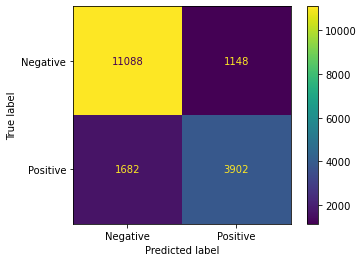

In [44]:
predictions = np.round(model.predict(t_x_t))
predictions_auc = (model.predict(t_x_t))

fpr, tpr, thresholds = roc_curve(test_y.reshape(1,-1)[0], predictions_auc.reshape(1,-1)[0], pos_label = 1)
auc_curve = auc(fpr, tpr)
cm = confusion_matrix(test_y.reshape(1,-1)[0], predictions.reshape(1,-1)[0], labels=[0,1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["Negative", "Positive"])
disp.plot()
print("Precision: %.4f\nAccuracy: %.4f\nF1: %.4f\nAUC: %.4f"%(precision_score(test_y.reshape(1,-1)[0], predictions.reshape(1,-1)[0]),
                                                  accuracy_score(test_y.reshape(1,-1)[0], predictions.reshape(1,-1)[0]),
                                                  f1_score(test_y.reshape(1,-1)[0], predictions.reshape(1,-1)[0]),
                                                  auc_curve))

In [34]:
joblib.dump(x_scaler,"%s_x_scaler_v%d.gz"%(mod_name, 3))
model.save("%s_v%d"%(mod_name, 3), save_format='h5')


In [42]:
model = load_model("%s_v%d"%(mod_name, 3), custom_objects={"tf": tf, "leaky_relu":tf.nn.leaky_relu})
x_scaler = joblib.load("%s_x_scaler_v%d.gz"%(mod_name, 3))

## Graph Example:

Vertical lines on a graphs indicate whether the prediction of whether the PHQ9 screening at a given appointment  exceeds 9 is correct or not. Green lines indicate that the prediction was correct, and red lines indicate that the prediciton was wrong. A 50% probability is the threshold-- if the model predicted that a high PHQ9 score is more likely than a low PHQ9 score for an appointment, then success or failure is determined by whether that matches with the actual result for that given appointment.

For example, if the probability of PHQ9 > 9 was predicted as 0.18 and the resulting score was a 4, a green line is drawn. If the probability of PHQ9 > 9 was 0.87 and the patient scored a 4, then a red line is drawn.

In [192]:
# Merge PHQ9 spike prediction column to original dataset then 
# create indicator column for whether predictions of > 50% panned out

fin_mod_out_v3 = pd.read_csv("fin_mod_out_v3.csv")[["CODED_PAT_ID", "APPT_SINCE_COHORT_ENTRY", "PHQ9_RISK_PROB"]]
fin_data_display = fin_dat.merge(fin_mod_out_v3, on = ["CODED_PAT_ID", "APPT_SINCE_COHORT_ENTRY"], how = "left")

fin_data_display.loc[((fin_data_display["PHQ9_SCORE"] > 9) & (fin_data_display["PHQ9_RISK_PROB"] >= 0.5)), "PHQ_PRED_RIGHT"] = 1
fin_data_display.loc[((fin_data_display["PHQ9_SCORE"] < 9) & (fin_data_display["PHQ9_RISK_PROB"] < 0.5)), "PHQ_PRED_RIGHT"] = 1
fin_data_display.loc[((fin_data_display["PHQ9_SCORE"] > 9) & (fin_data_display["PHQ9_RISK_PROB"] < 0.5)), "PHQ_PRED_WRONG"] = 1
fin_data_display.loc[((fin_data_display["PHQ9_SCORE"] < 9) & (fin_data_display["PHQ9_RISK_PROB"] >= 0.5)), "PHQ_PRED_WRONG"] = 1


In [196]:
#~~ Ignore this cell ~~

#TESTING: List of number of correct/incorrect predictions by row

#pd.set_option("display.max_rows", None)
# Potential Displays: A5228721, A175112
#fin_data_display[fin_data_display["PHQ_PRED_RIGHT"] == 1]#["CODED_PAT_ID"].unique()))#[["CODED_PAT_ID", "APPT_SINCE_COHORT_ENTRY", "PHQ9_SCORE", "PHQ9_STRENGTH", "BETA_BLOCKER_FLG", "LIPID_LOWERER_FLG", "ANTIHYPERTENSIVE_FLG", "PHQ9_RISK_PROB"]]
#fin_data_display[(fin_data_display["CODED_PAT_ID"] == "A8341353") & (fin_data_display["PHQ_PRED_WRONG"] == 1)]#[["DAYS_QUAL_TO_APPT"]]# & (fin_data_display[fin_data_display['PHQ_PRED_WRONG'] == 1])]
#list(fin_data_display[(fin_data_display["CODED_PAT_ID"] == "A8341353") & (fin_data_display["PHQ_PRED_WRONG"] == 1)][["DAYS_QUAL_TO_APPT"]].to_numpy().flatten())

#high_count_entries = fin_data_display[fin_data_display["PHQ_PRED_RIGHT"] == 1].groupby("CODED_PAT_ID").filter(lambda x: len(x) > 3)
#high_count_entries.value_counts("CODED_PAT_ID")


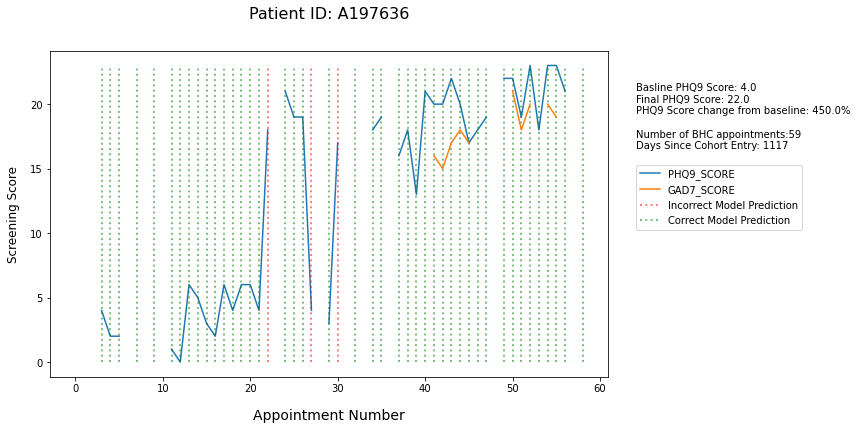

In [193]:
# "Appt" sets x axis to display appointment number
# "Days" sets x axis to dispay number of days since cohort entry

plt.rcParams['figure.figsize'] = [10, 6]
screeningGraph(fin_data_display, "A197636", "Appt")

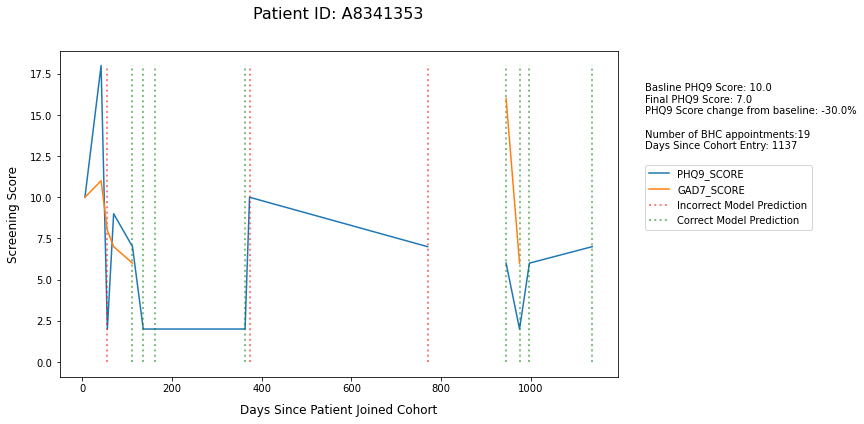

In [198]:
# "Appt" sets x axis to display appointment number
# "Days" sets x axis to dispay number of days since cohort entry

plt.rcParams['figure.figsize'] = [10, 6]
screeningGraph(fin_data_display, "A8341353", "Days")

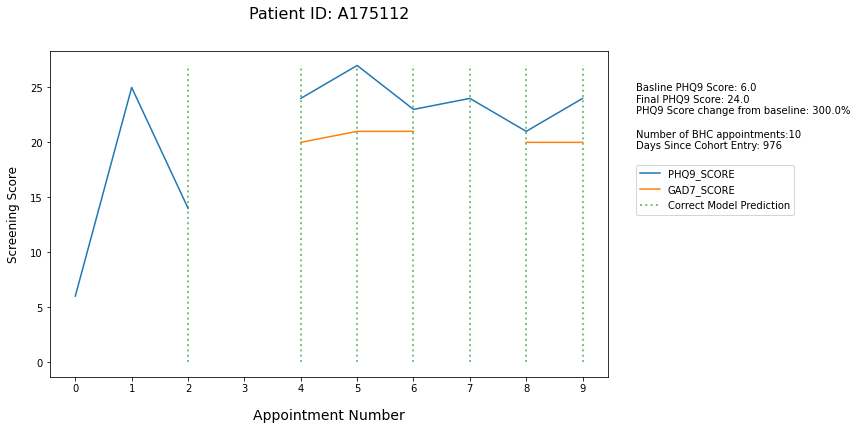

In [199]:
# "Appt" sets x axis to display appointment number
# "Days" sets x axis to dispay number of days since cohort entry

plt.rcParams['figure.figsize'] = [10, 6]
screeningGraph(fin_data_display, "A175112", "Days")